In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the CSV data
file_path = "csv downloaded from iNaturalist"
df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Basic info about the dataset
print("\n=== DATASET OVERVIEW ===")
print(df.info())

# Missing data analysis
print("\n=== MISSING DATA ANALYSIS ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_summary[missing_summary['Missing Count'] > 0])

# Categorical columns analysis
print("\n=== CATEGORICAL COLUMNS ANALYSIS ===")
categorical_cols = df.select_dtypes(include=['object']).columns

# Exclude columns we don't want to analyze
exclude_cols = ['uuid', 'observed_on', 'time_observed_at', 'observed_on_string', 'time_zone', 'created_at', 'updated_at']
relevant_categorical = [col for col in categorical_cols if col not in exclude_cols]

print(f"Relevant categorical columns: {relevant_categorical}")

for col in relevant_categorical:
    print(f"\n{col} - Value counts:")
    value_counts = df[col].value_counts()
    print(value_counts.head(10))  # Show top 10 values
    print(f"Total unique values: {df[col].nunique()}")

Dataset shape: (1136, 22)
Columns: ['id', 'uuid', 'observed_on_string', 'observed_on', 'time_observed_at', 'time_zone', 'created_at', 'updated_at', 'quality_grade', 'tag_list', 'description', 'num_identification_agreements', 'num_identification_disagreements', 'captive_cultivated', 'latitude', 'longitude', 'positional_accuracy', 'species_guess', 'scientific_name', 'common_name', 'iconic_taxon_name', 'taxon_id']

=== DATASET OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1136 non-null   int64  
 1   uuid                              1136 non-null   object 
 2   observed_on_string                1132 non-null   object 
 3   observed_on                       1132 non-null   object 
 4   time_observed_at                  1072 non-null   object 
 5   time_z


=== DEBUGGING TIME DATA ===
Sample observed_on values:
0    2011-08-12
1    1984-07-02
2    2012-08-14
3    2010-06-27
4    2013-06-12
5    2013-06-12
6    2013-06-10
7    2013-08-21
8    2007-08-25
9    2001-06-06
Name: observed_on, dtype: object

Observed_on data type: object

All time-related columns: ['time_observed_at', 'time_zone', 'updated_at']

Sample time_observed_at values:
0                        NaN
1                        NaN
2                        NaN
3                        NaN
4    2013-06-12 15:58:59 UTC
5    2013-06-12 14:11:18 UTC
6                        NaN
7                        NaN
8                        NaN
9                        NaN
Name: time_observed_at, dtype: object

Observations with valid time data: 1072 out of 1136


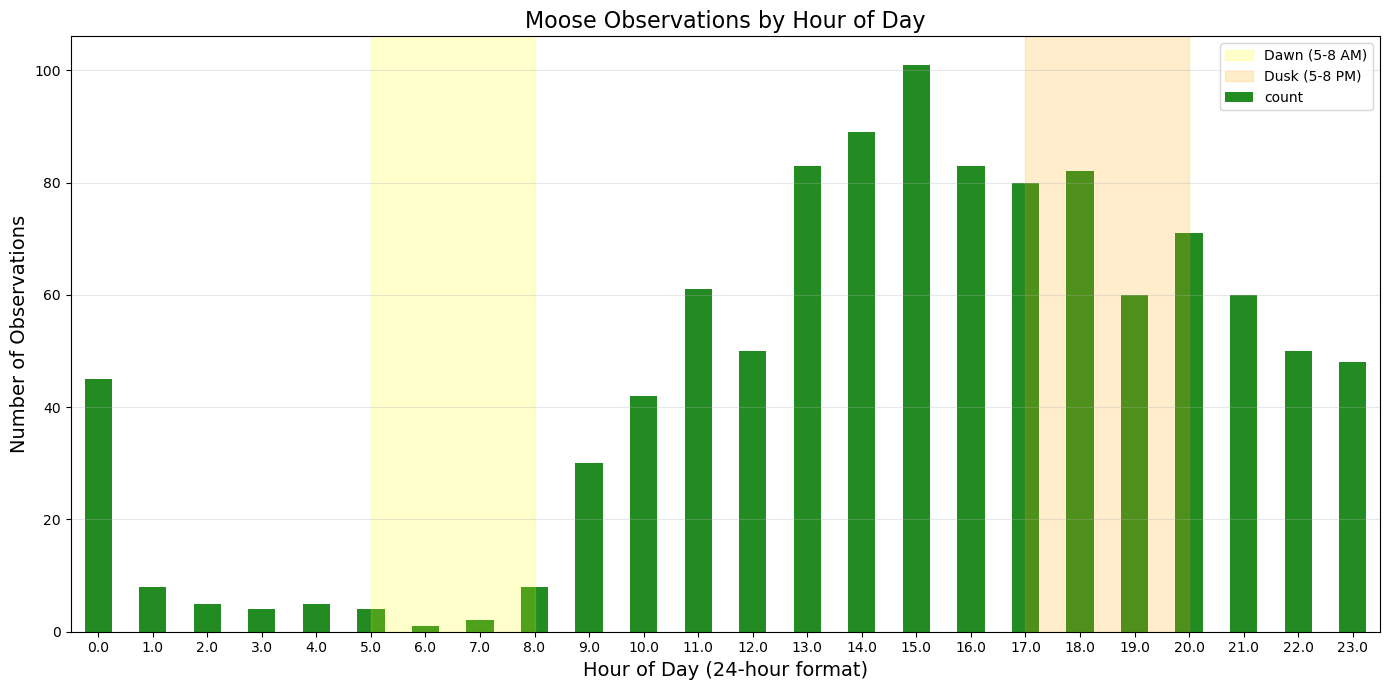


Hourly observation counts:
hour
0.0      45
1.0       8
2.0       5
3.0       4
4.0       5
5.0       4
6.0       1
7.0       2
8.0       8
9.0      30
10.0     42
11.0     61
12.0     50
13.0     83
14.0     89
15.0    101
16.0     83
17.0     80
18.0     82
19.0     60
20.0     71
21.0     60
22.0     50
23.0     48
Name: count, dtype: int64


In [11]:
# Time of Day Analysis
print("\n=== DEBUGGING TIME DATA ===")
print("Sample observed_on values:")
print(df['observed_on'].head(10))
print(f"\nObserved_on data type: {df['observed_on'].dtype}")

# Check for other time columns
time_related_cols = [col for col in df.columns if any(word in col.lower() for word in ['time', 'hour', 'date'])]
print(f"\nAll time-related columns: {time_related_cols}")

# Check if there's a separate time column
if 'time_observed_at' in df.columns:
    print("\nSample time_observed_at values:")
    print(df['time_observed_at'].head(10))
    
    # Use time_observed_at instead
    df['time_observed_at'] = pd.to_datetime(df['time_observed_at'], errors='coerce')
    df['hour'] = df['time_observed_at'].dt.hour
    
    # Remove rows where hour is NaN (no time data)
    valid_time_df = df.dropna(subset=['hour'])
    print(f"\nObservations with valid time data: {len(valid_time_df)} out of {len(df)}")
    
    if len(valid_time_df) > 0:
        hourly_counts = valid_time_df['hour'].value_counts().sort_index()
        
        plt.figure(figsize=(14, 7))
        ax = hourly_counts.plot(kind='bar', color='forestgreen')
        plt.title('Moose Observations by Hour of Day', fontsize=16)
        plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
        plt.ylabel('Number of Observations', fontsize=14)
        plt.xticks(rotation=0)
        plt.grid(True, axis='y', alpha=0.3)
        
        plt.axvspan(5, 8, alpha=0.2, color='yellow', label='Dawn (5-8 AM)')
        plt.axvspan(17, 20, alpha=0.2, color='orange', label='Dusk (5-8 PM)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print("\nHourly observation counts:")
        print(hourly_counts)
    else:
        print("No valid time data found")


=== SEASONAL ANALYSIS ===


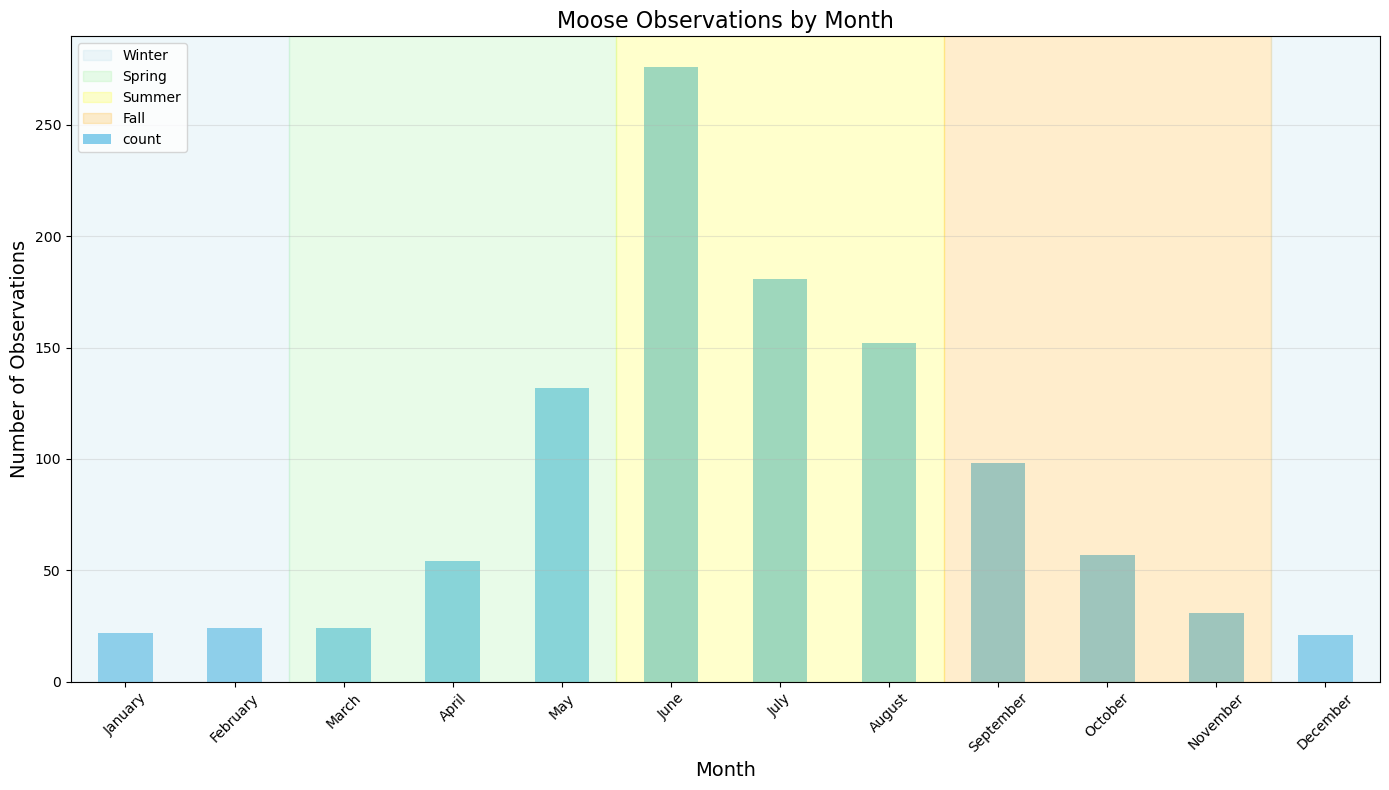


Observations by season:
season
Spring    210
Summer    609
Fall      186
Winter     67
Name: count, dtype: int64

Observations by month:
month_name
January       22
February      24
March         24
April         54
May          132
June         276
July         181
August       152
September     98
October       57
November      31
December      21
Name: count, dtype: int64


In [12]:
# Seasonal Analysis
print("\n=== SEASONAL ANALYSIS ===")

if 'time_observed_at' in df.columns:
    # Extract month and create seasonal groupings
    df['month'] = df['time_observed_at'].dt.month
    df['month_name'] = df['time_observed_at'].dt.month_name()
    
    # Define seasons
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
    
    df['season'] = df['month'].apply(get_season)
    
    # Count observations by month
    monthly_counts = df['month_name'].value_counts().reindex([
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'
    ])
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    ax = monthly_counts.plot(kind='bar', color='skyblue')
    
    plt.title('Moose Observations by Month', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Number of Observations', fontsize=14)
    plt.xticks(rotation=45)
    
    # Add seasonal background colors
    plt.axvspan(-0.5, 1.5, alpha=0.2, color='lightblue', label='Winter')
    plt.axvspan(1.5, 4.5, alpha=0.2, color='lightgreen', label='Spring') 
    plt.axvspan(4.5, 7.5, alpha=0.2, color='yellow', label='Summer')
    plt.axvspan(7.5, 10.5, alpha=0.2, color='orange', label='Fall')
    plt.axvspan(10.5, 12.5, alpha=0.2, color='lightblue')
    
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Show seasonal summary
    seasonal_counts = df['season'].value_counts().reindex(['Spring', 'Summer', 'Fall', 'Winter'])
    print("\nObservations by season:")
    print(seasonal_counts)
    
    # Show monthly data
    print("\nObservations by month:")
    print(monthly_counts)
    
else:
    print("No valid time data available for seasonal analysis")

Could not load USA data: HTTP Error 406: Not Acceptable
Using simplified North America outline
Points-only map saved as 'maine_moose_map_points_only.png'


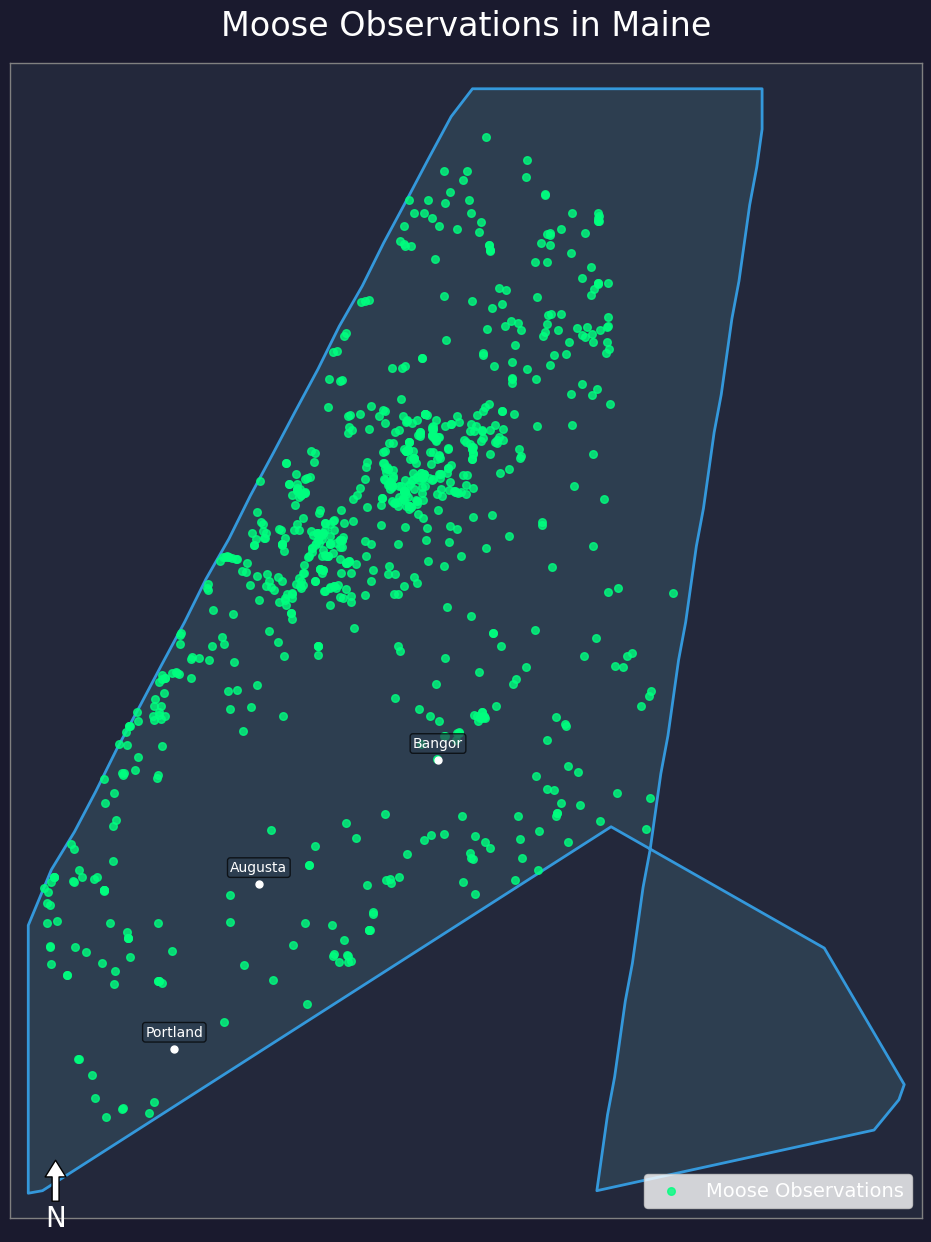

In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, time
import csv
from collections import defaultdict
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Create a dark theme map with only green points (no hexbin)
fig, ax = plt.subplots(figsize=(15, 15))

# Set a dark background
ax.set_facecolor('#1A1A2E')  # Dark blue for water
fig.patch.set_facecolor('#1A1A2E')

# Load USA data for context (optional)
usa = None
try:
    # Try alternative methods since geopandas.datasets is deprecated
    import urllib.request
    import zipfile
    
    # Download Natural Earth data directly if not already available
    ne_url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip"
    ne_file = "ne_110m_admin_0_countries.zip"
    
    if not os.path.exists("ne_110m_admin_0_countries.shp"):
        print("Downloading Natural Earth data...")
        urllib.request.urlretrieve(ne_url, ne_file)
        with zipfile.ZipFile(ne_file, 'r') as zip_ref:
            zip_ref.extractall()
        os.remove(ne_file)
    
    usa = gpd.read_file("ne_110m_admin_0_countries.shp")
    usa = usa[usa['CONTINENT'] == 'North America']
    if usa is not None and len(usa) > 0:
        usa.plot(ax=ax, color='#2D3748', edgecolor='#4A5568', linewidth=0.5, alpha=0.5)
        print("Loaded USA data from Natural Earth")
except Exception as e:
    print(f"Could not load USA data: {e}")
    # Create a simple North America outline as fallback
    try:
        na_coords = [
            (-130, 50), (-130, 25), (-65, 25), (-65, 50), (-130, 50)
        ]
        na_polygon = Polygon(na_coords)
        usa = gpd.GeoDataFrame({'geometry': [na_polygon]}, crs="EPSG:4326")
        usa.plot(ax=ax, color='#2D3748', edgecolor='#4A5568', linewidth=0.5, alpha=0.5)
        print("Using simplified North America outline")
    except Exception as e2:
        print(f"Could not create fallback USA data: {e2}")
        usa = None

# Create Maine boundary with cleaner, more accurate coordinates
if 'maine' not in globals():
    try:
        # More accurate Maine boundary coordinates
        maine_coords = [
            # Start at southwest corner
            (-71.08, 43.09),
            # Western border (straight line with NH)
            (-71.08, 45.30),
            # Northwest corner area
            (-70.82, 45.52),
            (-70.65, 45.75),
            (-70.45, 46.05),
            (-70.25, 46.35),
            (-70.05, 46.65),
            (-69.85, 46.85),
            (-69.65, 47.05),
            (-69.45, 47.25),
            (-69.25, 47.35),
            (-69.05, 47.40),
            (-68.85, 47.45),
            (-68.65, 47.46),
            # Northern border with Canada (straight line)
            (-67.79, 47.46),
            (-67.15, 47.46),
            (-66.95, 47.46),
            # Eastern coastline (simplified but more realistic)
            (-66.95, 47.20),
            (-67.05, 46.80),
            (-67.15, 46.40),
            (-67.25, 46.00),
            (-67.35, 45.60),
            (-67.45, 45.20),
            (-67.55, 44.80),
            (-67.65, 44.40),
            (-67.75, 44.00),
            (-67.85, 43.60),
            (-67.95, 43.20),
            # Southern coastline
            (-67.80, 43.15),
            (-67.50, 43.20),
            (-67.20, 43.25),
            (-66.90, 43.30),
            (-66.60, 43.35),
            # Penobscot Bay area
            (-69.00, 44.20),
            (-69.50, 44.00),
            (-70.00, 43.80),
            (-70.50, 43.60),
            (-71.00, 43.40),
            # Close the polygon
            (-71.08, 43.09)
        ]
        
        maine_polygon = Polygon(maine_coords)
        maine = gpd.GeoDataFrame({'NAME': ['Maine']}, geometry=[maine_polygon], crs="EPSG:4326")
        print("Created simplified but more accurate Maine boundary")
                
    except Exception as e:
        print(f"Could not load Maine data: {e}")
        # Simple rectangular fallback
        maine_coords = [(-71.08, 43.09), (-71.08, 47.46), (-66.95, 47.46), (-66.95, 43.09), (-71.08, 43.09)]
        maine_polygon = Polygon(maine_coords)
        maine = gpd.GeoDataFrame({'NAME': ['Maine']}, geometry=[maine_polygon], crs="EPSG:4326")
        print("Using rectangular Maine boundary as fallback")

# Plot Maine with a nice fill color
maine.plot(ax=ax, color='#2D3E50', edgecolor='#3498DB', linewidth=2)

# Create sample data if gdf not defined
if 'gdf' not in globals():
    # Create sample moose observation points
    sample_coords = [(-69.5, 45.2), (-68.8, 46.1), (-70.2, 44.8)]
    geometry = [Point(lon, lat) for lon, lat in sample_coords]
    gdf = gpd.GeoDataFrame({'id': range(len(geometry))}, geometry=geometry, crs="EPSG:4326")

# Plot individual observations with bright green markers
try:
    points_in_maine = gpd.clip(gdf, maine)
    points_in_maine.plot(ax=ax, markersize=30, marker='o', color='#00FF7F', 
                         alpha=0.8, label='Moose Observations')
except Exception as e:
    print(f"Could not clip points to Maine: {e}")
    gdf.plot(ax=ax, markersize=30, marker='o', color='#00FF7F', 
             alpha=0.8, label='Moose Observations')

# Add title and legend
plt.title('Moose Observations in Maine', fontsize=24, pad=20, color='white')
legend = plt.legend(loc='lower right', fontsize=14)
plt.setp(legend.get_texts(), color='white')

# Add a north arrow
arrow_x, arrow_y, arrow_length = 0.05, 0.05, 0.05
ax.annotate('N', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y-arrow_length),
            arrowprops=dict(facecolor='white', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax.transAxes)

# Define major cities if not defined
if 'cities' not in globals():
    cities = {
        'Portland': (-70.2553, 43.6591),
        'Bangor': (-68.7712, 44.8016),
        'Augusta': (-69.7795, 44.3106)
    }

# Add some major cities in Maine for reference
for city, (lon, lat) in cities.items():
    ax.plot(lon, lat, 'wo', markersize=5)
    ax.text(lon, lat + 0.05, city, fontsize=10, ha='center', color='white',
            bbox=dict(facecolor='#2D3E50', alpha=0.7, boxstyle='round,pad=0.2'))

# Remove axis labels but keep a simple grid
ax.set_xticks([])
ax.set_yticks([])
ax.grid(True, linestyle='--', alpha=0.2, color='gray')

# Add a border around the map
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('gray')
    spine.set_linewidth(1)

# Set the axis limits to Maine's bounds with a small buffer
maine_bounds = maine.total_bounds
ax.set_xlim(maine_bounds[0] - 0.1, maine_bounds[2] + 0.1)
ax.set_ylim(maine_bounds[1] - 0.1, maine_bounds[3] + 0.1)

# Save high-resolution version
plt.savefig('maine_moose_map_points_only.png', dpi=300, bbox_inches='tight')
print("Points-only map saved as 'maine_moose_map_points_only.png'")
plt.show()